In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.preprocessing import MinMaxScaler

In [19]:
def prepare_data(df, target_column='Close', sequence_length=60):
    features = df.drop(columns=[target_column]).values
    target = df[target_column].values

    scaler = MinMaxScaler()

    features_scaled = scaler.fit_transform(features)
    target_scaled = scaler.fit_transform(target.reshape(-1,1))

    X, y = [], []
    for i in range(sequence_length, len(features_scaled)):
        X.append(features_scaled[i-sequence_length:i])
        y.append(target_scaled[i,0])

    X, y = np.array(X), np.array(y)

    return X, y, scaler

In [20]:
def load_stock_data(filepath):
    df = pd.read_csv(filepath)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    return df

In [21]:
def train_lstm_model(stock,filepath):

    #load
    df = load_stock_data(filepath)
    X, y, scaler = prepare_data(df)

    #tt split
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    #model
    model = Sequential([
        Bidirectional(LSTM(units=64, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(0.1),
        Bidirectional(LSTM(units=50, return_sequences=False)),
        Dropout(0.1),
        Dense(units=25),
        Dense(units=1)
    ])

    model.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')

    #callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

    #train
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test,y_test),
        epochs=50,
        batch_size=32,
        callbacks=[early_stopping,reduce_lr],
        verbose=1
    )

    #make predictions
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)
    y_test_actual = scaler.inverse_transform(y_test.reshape(-1,1))

    #evaluate
    mse = tf.keras.losses.MeanSquaredError()(y_test_actual, predictions).numpy()
    r2 = 1 - (np.sum((y_test_actual - predictions)**2)/np.sum((y_test_actual - np.mean(y_test_actual))**2))

    print(f"Stock: {stock} | MSE: {mse:.5f}, R2: {r2:.5f}")

    #plot
    plt.figure(figsize=(10,5))
    plt.plot(df.index[-len(y_test_actual):], y_test_actual, label='Actual Close Price', color='blue')
    plt.plot(df.index[-len(y_test_actual):], predictions, label='Predicted Close Price', color='red')
    plt.title(f"{stock} stock Price Prediction using LSTM")
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.legend()
    plt.show()

Epoch 1/50
158/158 [==============================] - 13s 48ms/step - loss: 7.2279e-05 - val_loss: 0.0067 - lr: 0.0010
Epoch 2/50
158/158 [==============================] - 6s 39ms/step - loss: 6.5793e-06 - val_loss: 0.0084 - lr: 0.0010
Epoch 3/50
158/158 [==============================] - 6s 39ms/step - loss: 4.5441e-06 - val_loss: 0.0059 - lr: 0.0010
Epoch 4/50
158/158 [==============================] - 6s 39ms/step - loss: 3.8202e-06 - val_loss: 0.0045 - lr: 0.0010
Epoch 5/50
158/158 [==============================] - 6s 39ms/step - loss: 2.9830e-06 - val_loss: 0.0050 - lr: 0.0010
Epoch 6/50
158/158 [==============================] - 6s 39ms/step - loss: 2.6354e-06 - val_loss: 0.0040 - lr: 0.0010
Epoch 7/50
158/158 [==============================] - 6s 38ms/step - loss: 2.1005e-06 - val_loss: 0.0040 - lr: 0.0010
Epoch 8/50
158/158 [==============================] - 6s 39ms/step - loss: 1.9828e-06 - val_loss: 0.0038 - lr: 0.0010
Epoch 9/50
158/158 [==============================] - 6

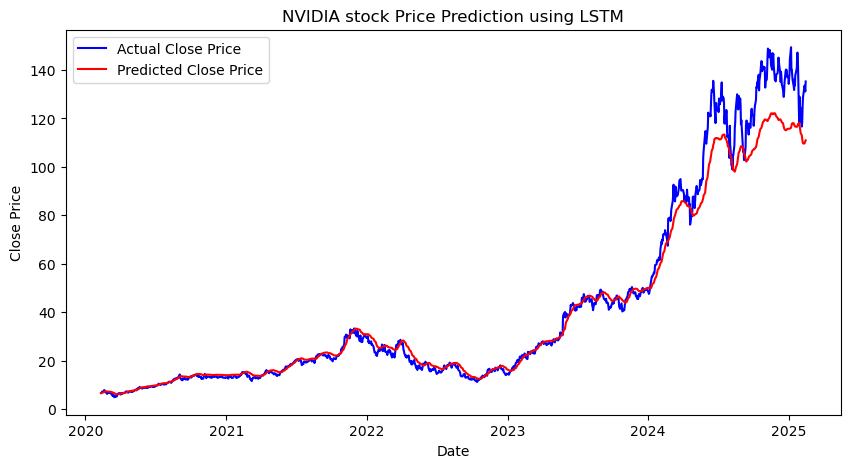

In [22]:
train_lstm_model('NVIDIA', '../data/nvidia_stock_features_selected.csv')

Epoch 1/50
272/272 [==============================] - 18s 44ms/step - loss: 1.9761e-04 - val_loss: 0.0046 - lr: 0.0010
Epoch 2/50
272/272 [==============================] - 11s 39ms/step - loss: 1.9832e-05 - val_loss: 0.0078 - lr: 0.0010
Epoch 3/50
272/272 [==============================] - 10s 38ms/step - loss: 1.2489e-05 - val_loss: 0.0065 - lr: 0.0010
Epoch 4/50
272/272 [==============================] - 10s 37ms/step - loss: 9.5948e-06 - val_loss: 0.0044 - lr: 0.0010
Epoch 5/50
272/272 [==============================] - 10s 37ms/step - loss: 7.7740e-06 - val_loss: 0.0074 - lr: 0.0010
Epoch 6/50
272/272 [==============================] - 10s 36ms/step - loss: 6.6120e-06 - val_loss: 0.0098 - lr: 0.0010
Epoch 7/50
272/272 [==============================] - 10s 36ms/step - loss: 5.7069e-06 - val_loss: 0.0131 - lr: 0.0010
Epoch 8/50
272/272 [==============================] - 10s 35ms/step - loss: 5.3886e-06 - val_loss: 0.0094 - lr: 0.0010
Epoch 9/50
272/272 [============================

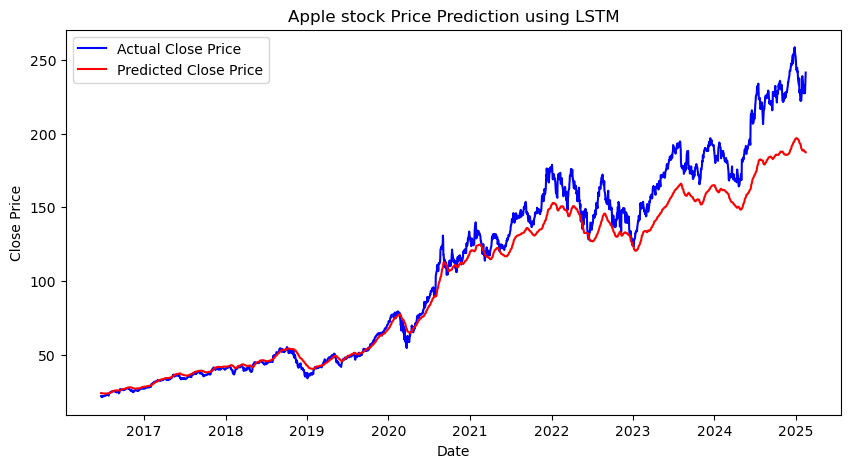

In [23]:
train_lstm_model('Apple', '../data/apple_stock_features_selected.csv')

Epoch 1/50
239/239 [==============================] - 16s 44ms/step - loss: 6.3078e-04 - val_loss: 0.0110 - lr: 0.0010
Epoch 2/50
239/239 [==============================] - 9s 37ms/step - loss: 3.9550e-05 - val_loss: 0.0031 - lr: 0.0010
Epoch 3/50
239/239 [==============================] - 9s 36ms/step - loss: 2.7080e-05 - val_loss: 0.0037 - lr: 0.0010
Epoch 4/50
239/239 [==============================] - 9s 38ms/step - loss: 2.0505e-05 - val_loss: 0.0037 - lr: 0.0010
Epoch 5/50
239/239 [==============================] - 10s 40ms/step - loss: 1.6467e-05 - val_loss: 0.0046 - lr: 0.0010
Epoch 6/50
239/239 [==============================] - 9s 38ms/step - loss: 1.3903e-05 - val_loss: 0.0050 - lr: 0.0010
Epoch 7/50
239/239 [==============================] - 9s 39ms/step - loss: 1.2096e-05 - val_loss: 0.0039 - lr: 0.0010
Epoch 8/50
239/239 [==============================] - 10s 41ms/step - loss: 9.7382e-06 - val_loss: 0.0068 - lr: 5.0000e-04
Epoch 9/50
239/239 [=============================

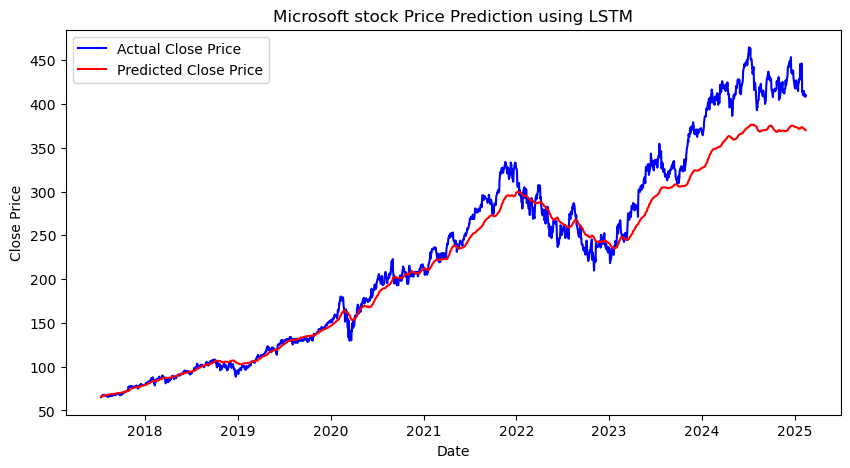

In [24]:
train_lstm_model('Microsoft', '../data/microsoft_stock_features_selected.csv')

We get pretty good results with the LSTM model let's try using exponential weights to place emphasis on more recent data points.

In [30]:
def custom_weighted_loss(y_true, y_pred):
    weights = tf.range(1, tf.shape(y_true)[0] + 1, dtype=tf.float32)
    weights = tf.math.exp(weights/tf.reduce_max(weights))
    mse = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)
    loss = mse(y_true, y_pred)
    return tf.reduce_mean(loss*weights)

In [32]:
def custom_lstm_model(stock, filepath):
    # Load data
    df = load_stock_data(filepath)
    X, y, scaler = prepare_data(df)

    # Train/test split
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Build model
    model = Sequential([
        Bidirectional(LSTM(units=64, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(0.1),
        Bidirectional(LSTM(units=50, return_sequences=False)),
        Dropout(0.1),
        Dense(units=25),
        Dense(units=1)
    ])

    # Compile model with the custom weighted loss function
    model.compile(optimizer=Adam(learning_rate=1e-3), loss=custom_weighted_loss)

    # Define callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=50,
        batch_size=32,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )

    # Make predictions
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)
    y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Evaluate the model
    mse = tf.keras.losses.MeanSquaredError()(y_test_actual, predictions).numpy()
    r2 = 1 - (np.sum((y_test_actual - predictions)**2) / np.sum((y_test_actual - np.mean(y_test_actual))**2))

    print(f"Stock: {stock} | MSE: {mse:.5f}, R2: {r2:.5f}")

    # Plot the predictions
    plt.figure(figsize=(10, 5))
    plt.plot(df.index[-len(y_test_actual):], y_test_actual, label='Actual Close Price', color='blue')
    plt.plot(df.index[-len(y_test_actual):], predictions, label='Predicted Close Price', color='red')
    plt.title(f"{stock} Stock Price Prediction using LSTM")
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.legend()
    plt.show()

Epoch 1/50
158/158 [==============================] - 14s 48ms/step - loss: 2.5100e-04 - val_loss: 0.0173 - lr: 0.0010
Epoch 2/50
158/158 [==============================] - 6s 39ms/step - loss: 5.3458e-06 - val_loss: 0.0164 - lr: 0.0010
Epoch 3/50
158/158 [==============================] - 6s 37ms/step - loss: 1.9608e-06 - val_loss: 0.0173 - lr: 0.0010
Epoch 4/50
158/158 [==============================] - 6s 39ms/step - loss: 1.2552e-06 - val_loss: 0.0172 - lr: 0.0010
Epoch 5/50
158/158 [==============================] - 6s 37ms/step - loss: 1.0579e-06 - val_loss: 0.0177 - lr: 0.0010
Epoch 6/50
158/158 [==============================] - 6s 38ms/step - loss: 1.1634e-06 - val_loss: 0.0220 - lr: 0.0010
Epoch 7/50
158/158 [==============================] - 6s 38ms/step - loss: 9.9792e-07 - val_loss: 0.0232 - lr: 0.0010
Epoch 8/50
158/158 [==============================] - 6s 37ms/step - loss: 7.6762e-07 - val_loss: 0.0277 - lr: 5.0000e-04
Epoch 9/50
158/158 [==============================]

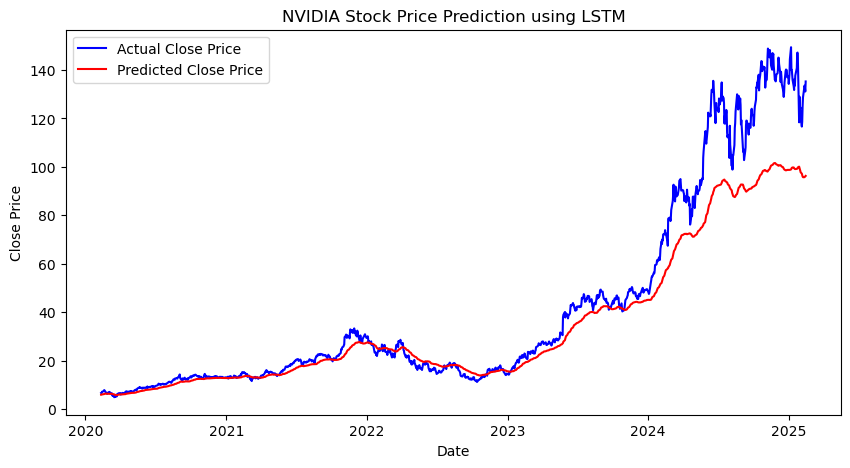

In [27]:
custom_lstm_model('NVIDIA', '../data/nvidia_stock_features_selected.csv')

Epoch 1/50
272/272 [==============================] - 18s 46ms/step - loss: 2.5225e-04 - val_loss: 0.0307 - lr: 0.0010
Epoch 2/50
272/272 [==============================] - 11s 39ms/step - loss: 5.8837e-06 - val_loss: 0.0580 - lr: 0.0010
Epoch 3/50
272/272 [==============================] - 10s 37ms/step - loss: 3.8789e-06 - val_loss: 0.0603 - lr: 0.0010
Epoch 4/50
272/272 [==============================] - 10s 38ms/step - loss: 3.3957e-06 - val_loss: 0.0525 - lr: 0.0010
Epoch 5/50
272/272 [==============================] - 10s 37ms/step - loss: 3.6519e-06 - val_loss: 0.0442 - lr: 0.0010
Epoch 6/50
272/272 [==============================] - 10s 38ms/step - loss: 2.9685e-06 - val_loss: 0.0392 - lr: 0.0010
Epoch 7/50
272/272 [==============================] - 10s 35ms/step - loss: 1.9502e-06 - val_loss: 0.0407 - lr: 5.0000e-04
Epoch 8/50
272/272 [==============================] - 10s 37ms/step - loss: 2.0694e-06 - val_loss: 0.0383 - lr: 5.0000e-04
Epoch 9/50
272/272 [====================

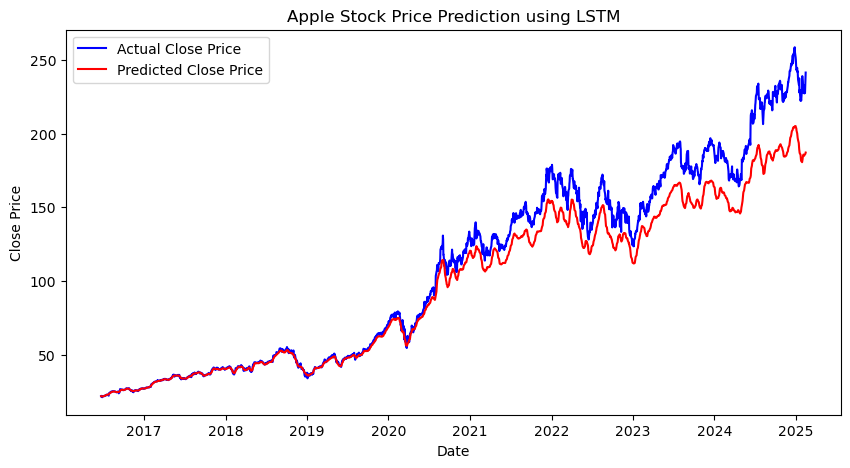

In [28]:
custom_lstm_model('Apple', '../data/apple_stock_features_selected.csv')

Epoch 1/50
239/239 [==============================] - 16s 45ms/step - loss: 8.1528e-04 - val_loss: 0.0063 - lr: 0.0010
Epoch 2/50
239/239 [==============================] - 9s 37ms/step - loss: 9.2105e-06 - val_loss: 0.0046 - lr: 0.0010
Epoch 3/50
239/239 [==============================] - 9s 36ms/step - loss: 5.1404e-06 - val_loss: 0.0078 - lr: 0.0010
Epoch 4/50
239/239 [==============================] - 9s 36ms/step - loss: 3.7973e-06 - val_loss: 0.0092 - lr: 0.0010
Epoch 5/50
239/239 [==============================] - 9s 37ms/step - loss: 3.1093e-06 - val_loss: 0.0106 - lr: 0.0010
Epoch 6/50
239/239 [==============================] - 9s 36ms/step - loss: 3.1275e-06 - val_loss: 0.0085 - lr: 0.0010
Epoch 7/50
239/239 [==============================] - 9s 37ms/step - loss: 2.8868e-06 - val_loss: 0.0106 - lr: 0.0010
Epoch 8/50
239/239 [==============================] - 9s 36ms/step - loss: 2.2459e-06 - val_loss: 0.0074 - lr: 5.0000e-04
Epoch 9/50
239/239 [==============================]

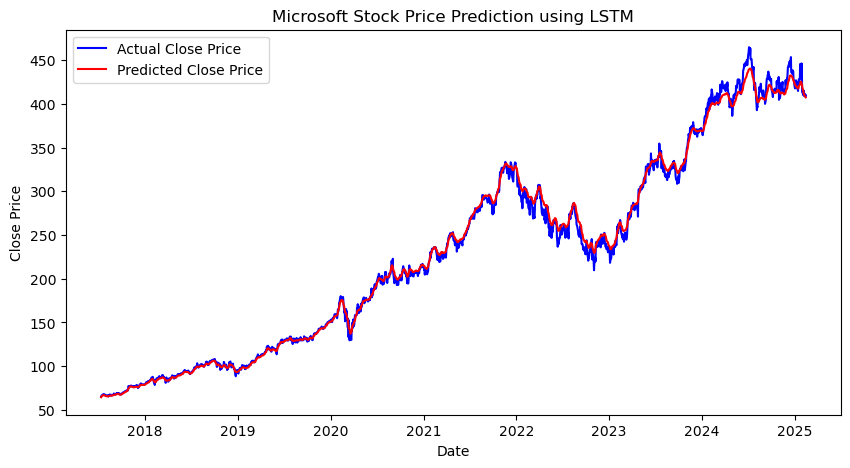

In [29]:
custom_lstm_model('Microsoft', '../data/microsoft_stock_features_selected.csv')

The model significantly degraded for our NVIDIA stock giving us a much higher MSE, the model did improve objectively for Apple whereas we had an excellent improvement for Microsoft, let's move on to GRUs to see if we get any further improved results.